# Region masking

This notebook demonstrates how to mask different regions defined in shape or geo json files and apply this mask to gridded data. 

The first example will demonstrate the application to global data. This example uses the country boundaries for Argentina as an example and calculates spatial as well as temporal averages of ERA5 data over Argentina. 

Parts of the code is with courtesy of https://www.guillaumedueymes.com/post/shapefiles_country/ and https://regionmask.readthedocs.io/en/stable/ 

The second part will apply masking across German municipalities using high resolution model output on rotated grids. 

The shape files were downloaded at the following locations:
* Argentina : https://map.igismap.com/share-map/export-layer/Argentina_AL2-AL2/c0e190d8267e36708f955d7ab048990d
* Germany : https://www.arcgis.com/home/item.html?id=ae25571c60d94ce5b7fcbf74e27c00e0#!

* The notebook can be viewed on the [Notebook Viewer](https://nbviewer.jupyter.org/urls/gitlab.dkrz.de/freva/codesnippets/-/raw/master/notebooks/MaskRegionFromShapeFile.ipynb?flush_cache=true)

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import xarray as xr

Define the paths to the ERA5 dataset and the shapefiles.

In [2]:
inp_path = '/work/ch1187/regiklim-ces/data4freva/reanalysis/reanalysis/ECMWF/IFS/ERA5/mon/atmos/prw/r1i1p1/'
inp_files = sorted([str(f) for f in Path(inp_path).rglob('*.nc')])
shape_file_arg = list(Path('__file__').absolute().parents)[1] / 'data' / 'shape_data' / 'Igismap.zip'
shape_file_de = list(Path('__file__').absolute().parents)[1] / 'data' / 'shape_data' / 'vg2500_geo84.zip'

In [3]:
inp_files[-3:]

['/work/ch1187/regiklim-ces/data4freva/reanalysis/reanalysis/ECMWF/IFS/ERA5/mon/atmos/prw/r1i1p1/prw_Amon_reanalysis_era5_r1i1p1_20180101-20181231.nc',
 '/work/ch1187/regiklim-ces/data4freva/reanalysis/reanalysis/ECMWF/IFS/ERA5/mon/atmos/prw/r1i1p1/prw_Amon_reanalysis_era5_r1i1p1_20190101-20191231.nc',
 '/work/ch1187/regiklim-ces/data4freva/reanalysis/reanalysis/ECMWF/IFS/ERA5/mon/atmos/prw/r1i1p1/prw_Amon_reanalysis_era5_r1i1p1_20200101-20201231.nc']

In [4]:
# Read the shapefile with geopandas
provinces_arg = gp.read_file("zip://" + str(shape_file_arg))
provinces_arg

id country       name     enname    locname              offname  \
0  286393     ARG  Argentina  Argentina  Argentina  República Argentina   

         boundary  adminlevel wikidata     wikimedia            timestamp  \
0  administrative           2     Q414  es:Argentina  2020-01-02 22:59:02   

   note      path     rpath iso3166_2  \
0  None  0,286393  286393,0      None   

                                            geometry  
0  MULTIPOLYGON (((-66.54668 -55.06064, -66.54654...

Smoke test: create a simple region mask and plot the resulting mask

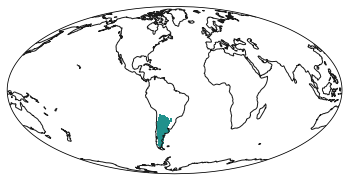

In [5]:
lon = np.arange(-180, 180)
lat = np.arange(-90, 90)
mask = regionmask.mask_geopandas(provinces_arg['geometry'], lon, lat)
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Mollweide(-50)))
mask.plot(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False,
)
ax.coastlines(color="0.1")

# Part I: Create a mask for a global dataset

Frist, read the ERA5 dataset

In [6]:
era_5 = xr.open_mfdataset([inp_files[-3:]], combine='by_coords', parallel=True)
era_5

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 640, lon: 1280, time: 29)
Coordinates:
  * time      (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2020-05-01
  * lon       (lon) float64 0.0 0.2812 0.5625 0.8438 ... 358.9 359.2 359.4 359.7
  * lat       (lat) float64 -89.78 -89.51 -89.23 -88.95 ... 89.23 89.51 89.78
Dimensions without coordinates: bnds
Data variables:
    lon_bnds  (time, lon, bnds) float64 dask.array<chunksize=(12, 1280, 2), meta=np.ndarray>
    lat_bnds  (time, lat, bnds) float64 dask.array<chunksize=(12, 640, 2), meta=np.ndarray>
    prw       (time, lat, lon) float32 dask.array<chunksize=(12, 640, 1280), meta=np.ndarray>
Attributes:
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    history:        Mon Oct 12 15:04:04 2020: cdo -f nc4 -s -mergetime era5dk...
    institution:    European Centre for Medium-Range Weather Forecasts
    Conventions:    CF-1.6
    tracking_id:    d5b13485-16f3-5f65-8dfd-cf03615bcc01
    creation_date:  2020-10-10T01:10:54Z
    CDO:            Climate Data Operators version 1.9.6 (http://mpimet.mpg.d...
    license:        Contains modified Copernicus Atmosphere Monitoring Servic...

ERA5 longitude vector runs from 0 to 360. The shapfiles have thier polygones defined between -180 and 180. Hence the ERA5 longitude vector needs to be transformed. This is easy:

In [7]:
era_5 = era_5.assign_coords(lon=(((era_5.lon + 180) % 360) - 180)).sortby('lon')
era_5

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 640, lon: 1280, time: 29)
Coordinates:
  * time      (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2020-05-01
  * lon       (lon) float64 -180.0 -179.7 -179.4 -179.2 ... 179.2 179.4 179.7
  * lat       (lat) float64 -89.78 -89.51 -89.23 -88.95 ... 89.23 89.51 89.78
Dimensions without coordinates: bnds
Data variables:
    lon_bnds  (time, lon, bnds) float64 dask.array<chunksize=(12, 1280, 2), meta=np.ndarray>
    lat_bnds  (time, lat, bnds) float64 dask.array<chunksize=(12, 640, 2), meta=np.ndarray>
    prw       (time, lat, lon) float32 dask.array<chunksize=(12, 640, 1280), meta=np.ndarray>
Attributes:
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    history:        Mon Oct 12 15:04:04 2020: cdo -f nc4 -s -mergetime era5dk...
    institution:    European Centre for Medium-Range Weather Forecasts
    Conventions:    CF-1.6
    tracking_id:    d5b13485-16f3-5f65-8dfd-cf03615bcc01
    creation_date:  2020-10-10T01:10:54Z
    CDO:            Climate Data Operators version 1.9.6 (http://mpimet.mpg.d...
    license:        Contains modified Copernicus Atmosphere Monitoring Servic...

Let's create a mask from all regions in the `provinces_arg` shape data:

In [8]:
outlines = list(provinces_arg.geometry.values[i] for i in range(0, provinces_arg.shape[0]))
id_list = list(provinces_arg['id'].values)
id_list_unique = set(id_list)
indexes = [id_list.index(x) for x in id_list_unique]
countries_mask_poly = regionmask.Regions(name='id',
                                             numbers=indexes,
                                             names=provinces_arg.name[indexes],
                                             abbrevs=provinces_arg.country[indexes],
                                             outlines=outlines)
mask = countries_mask_poly.mask(era_5.isel(time=0), lat_name='lat', lon_name='lon') + 1
mask                                            

<xarray.DataArray 'region' (lat: 640, lon: 1280)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -89.78 -89.51 -89.23 -88.95 ... 89.23 89.51 89.78
  * lon      (lon) float64 -180.0 -179.7 -179.4 -179.2 ... 179.2 179.4 179.7

This mask can be used to calculate spatial and temporal averages or simply save the data:

In [9]:
time_mean = (era_5['prw'] * mask.data).mean(dim='time', keep_attrs=True) # temporal avg
fld_mean = (era_5['prw'] * mask.data).mean(dim=('lon', 'lat'), keep_attrs=True) # spatial avg
time_mean.attrs = fld_mean.attrs = era_5['prw'].attrs

Plotting the temporal mean is also very easy:

/work/ch1187/regiklim-ces/freva/xarray/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


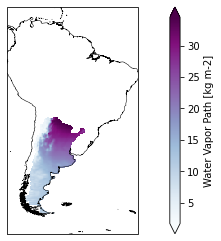

In [10]:
proj = ccrs.PlateCarree(central_longitude=-65.) # Create ylindrical projections
fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(111, projection=proj)
plot = time_mean.plot(ax=ax,
                      transform=ccrs.PlateCarree(), # This is important
                      cmap='BuPu',
                      cbar_kwargs={
                                   'extend': 'both',
                                   'aspect': 20,
                                   'orientation': 'vertical'},
                                   
                     )

ax.set_extent((-80, -35, -60, 15))
_ = ax.coastlines(resolution='10m', lw=0.5)
fig.subplots_adjust(left=0.01, right=0.99, hspace=0, wspace=0, top=1, bottom=0.3)

Same for the spatial mean (time series):

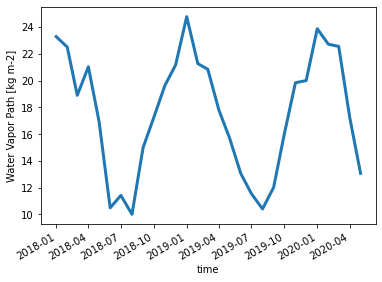

In [11]:
_ = fld_mean.plot(linewidth=3)

# Part II : Masking regional data on rotated grids

Let's get the data from 3km simulations across Germany first. This time we are going to look at vertical integrated cloud water. The general strategy is similar to the one outlined above. The only difference is, that we will use the a 2D lon/lat *matrix* instead of the a 1D lon/lat *vector* from above. This 2D matrix contians the longitude and latitude coordinates in the global *curvilinear* space.

In [12]:
inp_path = Path('/work/ch1187/regiklim-ces/data4freva/model/regional/cordex/EUC-0275/GERICS/ECMWF-ERAINT-GERICS-REMO2015/evaluation/day')
in_files = sorted([str(f) for f in inp_path.rglob('cllvi*.nc')])
in_files[-3:]

['/work/ch1187/regiklim-ces/data4freva/model/regional/cordex/EUC-0275/GERICS/ECMWF-ERAINT-GERICS-REMO2015/evaluation/day/atmos/day/r1i1p1/v20201205/cllvi/cllvi_day_ECMWF-ERAINT-GERICS-REMO2015_evaluation_r1i1p1_200910010030-200910312330.nc',
 '/work/ch1187/regiklim-ces/data4freva/model/regional/cordex/EUC-0275/GERICS/ECMWF-ERAINT-GERICS-REMO2015/evaluation/day/atmos/day/r1i1p1/v20201205/cllvi/cllvi_day_ECMWF-ERAINT-GERICS-REMO2015_evaluation_r1i1p1_200911010030-200911302330.nc',
 '/work/ch1187/regiklim-ces/data4freva/model/regional/cordex/EUC-0275/GERICS/ECMWF-ERAINT-GERICS-REMO2015/evaluation/day/atmos/day/r1i1p1/v20201205/cllvi/cllvi_day_ECMWF-ERAINT-GERICS-REMO2015_evaluation_r1i1p1_200912010030-200912312330.nc']

In [13]:
eucp = xr.open_mfdataset(in_files[-3:], combine='by_coords', parallel=True)
eucp

<xarray.Dataset>
Dimensions:       (rlat: 311, rlon: 271, time: 92)
Coordinates:
  * time          (time) datetime64[ns] 2009-10-01 2009-10-02 ... 2009-12-31
  * rlon          (rlon) float64 -8.286 -8.259 -8.231 ... -0.8888 -0.8613
  * rlat          (rlat) float64 -4.056 -4.029 -4.001 ... 4.414 4.441 4.469
Data variables:
    rotated_pole  (time) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    cllvi         (time, rlat, rlon) float32 dask.array<chunksize=(31, 311, 271), meta=np.ndarray>
Attributes: (12/28)
    CDI:                            Climate Data Interface version 1.9.8 (htt...
    history:                        Mon Mar 29 15:31:50 2021: cdo -O -s -f nc...
    Conventions:                    CF-1.6
    tracking_id:                    9c1e54c5-ec5c-4549-8dc6-f609b9f06201
    creation_date:                  2021-03-29T15:31:50Z
    CDO:                            Climate Data Operators version 1.9.8 (htt...
    ...                             ...
    driving_experiment:             ECMWF-ERAINT, evaluation, r1i1p1
    driving_model_id:               ECMWF-ERAINT
    driving_experiment_name:        evaluation
    driving_model_ensemble_member:  r1i1p1
    rcm_version_id:                 v1
    cmor_version:                   2.9.1

In [14]:
# The rotated pole configuration
pole = eucp['rotated_pole'].attrs
pole

{'grid_mapping_name': 'rotated_latitude_longitude',
 'grid_north_pole_longitude': -162.0,
 'grid_north_pole_latitude': 39.25}

The Cartopy cartopy libary can handle roated poles, hence we can plot the data directly without remapping. The only thing we have to do here is creating the projection by telling cartopy the coordinates of the roated pole.

In [15]:
rotated_pole = ccrs.RotatedPole(pole_latitude=pole['grid_north_pole_latitude'],
                                pole_longitude=pole['grid_north_pole_longitude'])

Smoke test: Let's plot a global map with the above defined projection:

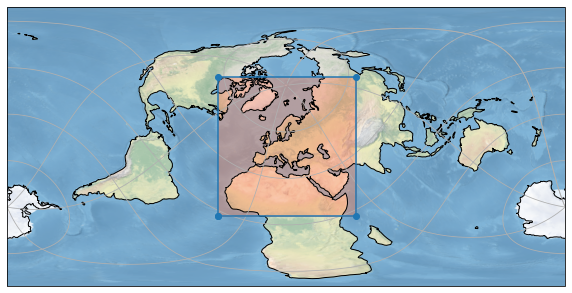

In [16]:
x, y = [-44, -44, 45, 45, -44], [-45, 45, 45, -45, -45]
fig, ax = plt.subplots(subplot_kw=dict(projection=rotated_pole), figsize=(10, 10))
ax.stock_img()
ax.coastlines()
ax.plot(x, y, marker='o', transform=rotated_pole)
ax.fill(x, y, color='coral', transform=rotated_pole, alpha=0.4)
_ = ax.gridlines()

Usually cordex data comes with the curvilinear global 2D lon/lat coordinates. This data set hasn't this information. We only have the rotated coordinates. To create the global ones we use cartopy's `transfrom_points` method to transform the roated coordinates into unrotated global coordinates.

In [17]:
Y, X = np.meshgrid(eucp.rlat.values, eucp.rlon.values) # Create a 2d matrix
cyl = ccrs.PlateCarree() # Target project (global cylindrical projection)
lon, lat, _ = cyl.transform_points(rotated_pole, X, Y).T
# Add the lon/lat data to the eucp data set
eucp['lat'] = xr.DataArray(lat, name='lat', dims=('rlat', 'rlon'), coords={'rlat':eucp.rlat, 'rlon':eucp.rlon})
eucp['lon'] = xr.DataArray(lon, name='lon', dims=('rlat', 'rlon'), coords={'rlat':eucp.rlat, 'rlon':eucp.rlon})

In [18]:
# Read the shape file
provinces_de = gp.read_file("zip://" + str(shape_file_de))
provinces_de

USE  RS        RS_ALT                     GEN    SHAPE_LENG    SHAPE_AREA  \
0     2  02  020000000000                 Hamburg  1.752538e+05  7.605398e+08   
1     2  03  030000000000           Niedersachsen  2.016496e+06  4.771641e+10   
2     2  04  040000000000                  Bremen  1.549716e+05  4.054809e+08   
3     2  05  050000000000     Nordrhein-Westfalen  1.352108e+06  3.404727e+10   
4     2  06  060000000000                  Hessen  1.105093e+06  2.109232e+10   
5     2  07  070000000000         Rheinland-Pfalz  9.106504e+05  1.983491e+10   
6     2  08  080000000000       Baden-Württemberg  1.298892e+06  3.580140e+10   
7     2  09  090000000000                  Bayern  2.046039e+06  7.055007e+10   
8     2  10  100000000000                Saarland  2.829108e+05  2.578542e+09   
9     2  11  110000000000                  Berlin  1.807512e+05  8.864801e+08   
10    2  12  120000000000             Brandenburg  1.295460e+06  2.965390e+10   
11    2  13  130000000000  Mecklenburg-Vorpommern  1.780981e+06  2.304468e+10   
12    2  14  140000000000                 Sachsen  9.792943e+05  1.840164e+10   
13    2  15  150000000000          Sachsen-Anhalt  9.490968e+05  2.049498e+10   
14    2  16  160000000000               Thüringen  9.619427e+05  1.617853e+10   
15    2  01  010000000000      Schleswig-Holstein  1.217256e+06  1.585743e+10   

                                             geometry  
0   MULTIPOLYGON (((10.19114 53.72299, 10.18210 53...  
1   MULTIPOLYGON (((8.68962 53.87999, 8.69297 53.8...  
2   MULTIPOLYGON (((8.52976 53.21640, 8.55399 53.2...  
3   POLYGON ((8.66673 52.52149, 8.70289 52.50053, ...  
4   POLYGON ((9.50560 51.62777, 9.50842 51.62712, ...  
5   POLYGON ((7.84657 50.87861, 7.85901 50.87733, ...  
6   MULTIPOLYGON (((9.64634 49.77782, 9.63806 49.7...  
7   POLYGON ((10.47207 47.56964, 10.47319 47.57081...  
8   POLYGON ((7.06853 49.62349, 7.08023 49.61196, ...  
9   POLYGON ((13.61192 52.54332, 13.62461 52.53797...  
10  POLYGON ((13.87357 53.47515, 13.91610 53.45652...  
11  MULTIPOLYGON (((12.66717 54.44292, 12.67209 54...  
12  POLYGON ((12.90084 51.64699, 12.91309 51.64488...  
13  POLYGON ((11.63624 53.00680, 11.64091 53.00601...  
14  POLYGON ((10.86498 51.62927, 10.89515 51.61114...  
15  MULTIPOLYGON (((8.44703 55.05034, 8.46057 55.0...

In [19]:
# Define Hamburg as target region and create the mask
HH = provinces_de.loc[provinces_de.GEN == 'Hamburg']
outlines = list(HH.geometry.values[i] for i in range(0, HH.shape[0]))
id_list = list(HH.index)
id_list_unique = set(id_list)
indexes = [id_list.index(x) for x in id_list_unique]
city_mask_poly = regionmask.Regions(name='id',
                                    numbers=indexes,
                                    names=provinces_de.GEN[indexes],
                                    abbrevs=provinces_de.GEN[indexes],
                                    outlines=outlines)
mask = city_mask_poly.mask(eucp.isel(time=0), lat_name='lat', lon_name='lon') + 1
mask

<xarray.DataArray (rlat: 311, rlon: 271)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * rlat     (rlat) float64 -4.056 -4.029 -4.001 -3.974 ... 4.414 4.441 4.469
  * rlon     (rlon) float64 -8.286 -8.259 -8.231 ... -0.9163 -0.8888 -0.8613
    lat      (rlat, rlon) float64 46.02 46.03 46.03 46.04 ... 55.21 55.21 55.21
    lon      (rlat, rlon) float64 6.051 6.09 6.129 6.168 ... 16.4 16.45 16.5

Get the max, min coordinates where the mask is not NaN (and add a 1 degree border)

In [20]:
minLon = eucp['lon'].values.ravel()[int((eucp['lon']*mask).argmin().values)] - 0.5
minLat = eucp['lat'].values.ravel()[int((eucp['lat']*mask).argmin().values)] - 0.5
maxLon = eucp['lon'].values.ravel()[int((eucp['lon']*mask).argmax().values)] + 0.5
maxLat = eucp['lat'].values.ravel()[int((eucp['lat']*mask).argmax().values)] + 0.5
print(f'{minLon} - {maxLon}')
print(f'{minLat} - {maxLat}')
# Tranfrom these points into rotated coordinates
xs, ys, _ = rotated_pole.transform_points(cyl, np.r_[minLon, maxLon], np.r_[minLat, maxLat]).T

7.994376685683303 - 10.770689965487314
52.90522046633116 - 54.42439385372021


As for the global case the mask can be used to calculate spatial and temporal averages or simply save the data:

In [21]:
time_mean_hh = (eucp['cllvi'] * mask.data).mean(dim='time', keep_attrs=True) # temporal avg
fld_mean_hh = (eucp['cllvi'] * mask.data).mean(dim=('rlon', 'rlat'), keep_attrs=True) # spatial avg
time_mean_hh.attrs = fld_mean_hh.attrs = eucp['cllvi'].attrs

/work/ch1187/regiklim-ces/freva/xarray/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


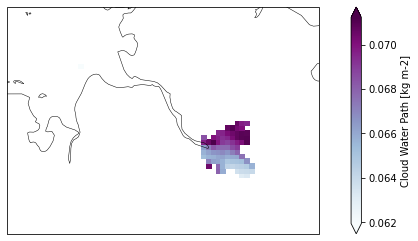

In [22]:
fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(111, projection=rotated_pole)
plot = time_mean_hh.plot(ax=ax,
                      transform=rotated_pole, # This is important
                      cmap='BuPu',
                      cbar_kwargs={
                                   'extend': 'both',
                                   'aspect': 20,
                                   'orientation': 'vertical'},
                                   
                     )

_ = ax.coastlines(resolution='10m', lw=0.5)
fig.subplots_adjust(left=0.01, right=0.99, hspace=0, wspace=0, top=1, bottom=0.3)
# Set the plot limits to a wider Hamburg area
ax.set_xlim(xs)
_ = ax.set_ylim(ys)

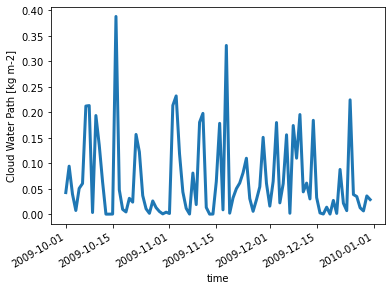

In [23]:
_ = fld_mean_hh.plot(linewidth=3)